In [1]:
import os
import sys
import itertools
from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd
from scipy.stats import spearmanr

from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn3
import seaborn as sns

import torch
from torch import nn, optim
from transformers import BertConfig, BertTokenizer, BertModel, BertForMaskedLM#, BertLayer, BertEmbeddings
from transformers.modeling_bert import BertLayer, BertEmbeddings

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# re-load functions
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%config InlineBackend.figure_formats = {'png', 'retina'}

In [ ]:
DEVICE = 'cpu'

## model を load して snapshot ensemble 試してみる

In [50]:
# q_ckpt = torch.load('../mnt/checkpoints/e061/0/fold_0_epoch_4_0.37116_0.42512_checkpoint.pth')
q_ckpt = torch.load('../mnt/checkpoints/e059/0/fold_0_epoch_4_0.37282_0.42366_checkpoint.pth')

In [7]:
q_ckpt.keys()

dict_keys(['current_fold', 'current_epoch', 'model_state_dict', 'optim_state_dict', 'scheduler_state_dict', 'histories', 'val_y_preds', 'val_y_trues', 'val_qa_ids'])

In [51]:
y_preds = q_ckpt['val_y_preds']
y_trues = q_ckpt['val_y_trues']

In [60]:
from scipy.stats import spearmanr

def compute_spearmanr(trues, preds):
    rhos = []
    for col_trues, col_pred in zip(trues.T, preds.T):
        rhos.append(
            spearmanr(
                col_trues,
                col_pred).correlation)
#                col_pred +
#                np.random.normal(
#                    0,
#                    1e-7,
#                    col_pred.shape[0])).correlation)
    return rhos

In [ ]:
# sys.path.append('')

In [52]:
import sys
import pickle
from functools import partial
from glob import glob

import numpy as np
import pandas as pd
import scipy as sp
import torch
from scipy.stats import spearmanr
from tqdm import tqdm

class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """

    def __init__(self):
        self.coef_ = 0

    def _spearmanr_loss(self, coef, X, y, labels):
        """
        Get loss according to
        using current coefficients
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) +
                     [np.inf], labels=labels)

        # return -np.mean(spearmanr(y, X_p).correlation)
        return -spearmanr(y, X_p).correlation

    def fit(self, X, y, initial_coef):
        """
        Optimize rounding thresholds
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        labels = self.labels
        loss_partial = partial(self._spearmanr_loss, X=X, y=y, labels=labels)
        self.coef_ = sp.optimize.minimize(
            # loss_partial, initial_coef, method='Powell')
            loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        labels = self.labels
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) +
                      [np.inf], labels=labels)
        # [np.inf], labels=[0, 1, 2, 3])

    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

    def set_labels(self, labels):
        self.labels = labels

In [17]:
y_trues.shape

(1216, 21)

In [76]:
#opt_threshs = []
opt_y_preds = []

for i in tqdm(list(range(21))):
    optR = OptimizedRounder()
    labels = np.sort(np.unique(y_trues[:, i]))
    optR.set_labels(labels)
    optR.fit(y_preds[:, i], y_trues[:, i], opt_threshs[i])
    #optR.fit(y_preds[:, i], y_trues[:, i], (labels[:-1] + labels[1:]) / 2)
    #opt_threshs.append(optR.coefficients())
    opt_threshs[i] = optR.coefficients()
    opt_y_preds.append((optR.predict(y_preds[:, i], optR.coefficients())))

opt_y_preds = np.asarray(opt_y_preds).T

100%|██████████| 21/21 [00:07<00:00,  2.74it/s]


In [38]:
opt_threshs

[array([0.39302227, 0.47714736, 0.53073788, 0.61123846, 0.7214163 ,
        0.80191743, 0.86528057, 0.94014891]),
 array([0.39730706, 0.47545026, 0.53606698, 0.63954269, 0.7094524 ,
        0.79974446, 0.8605658 , 0.95144991]),
 array([0.15416667, 0.41796875, 0.62161458, 0.82552083]),
 array([0.16185593, 0.42727512, 0.61892357, 0.81198814]),
 array([0.15382093, 0.3733791 , 0.64216916, 0.96862651]),
 array([0.16954956, 0.42698669, 0.62090963, 0.77905273]),
 array([0.39337905, 0.4769847 , 0.53451731, 0.5977414 , 0.72068913,
        0.81480649, 0.87722019, 0.95478971]),
 array([0.36257722, 0.48256197, 0.52506614, 0.62510089, 0.7304953 ,
        0.78287694, 0.87356808, 0.97216328]),
 array([0.18282943, 0.33599756, 0.64340394, 0.8457047 ]),
 array([0.16666667, 0.41666667, 0.58333333]),
 array([0.16131903, 0.41386874, 0.59469924, 0.85130211]),
 array([0.1559806 , 0.42121014, 0.64533821, 0.80955015]),
 array([0.17083333, 0.42708333, 0.55416667, 0.85416667]),
 array([0.16666667, 0.41666667, 0.

In [79]:
labels

array([0.        , 0.66666667])

[0.33333333]


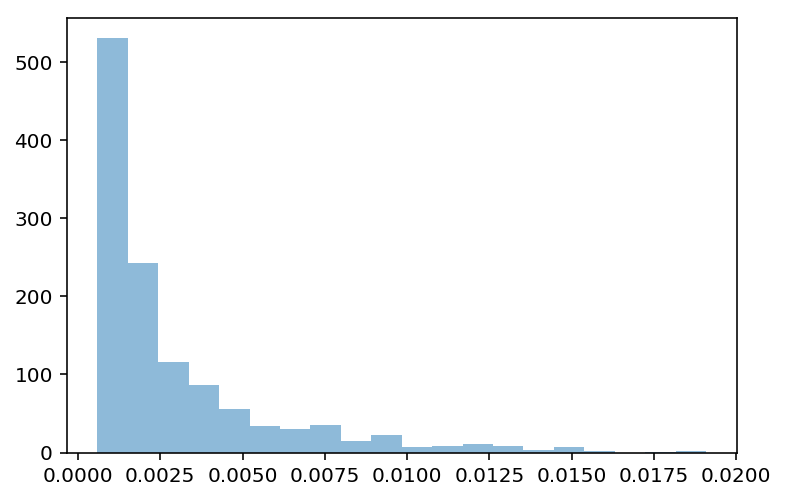

In [78]:
labels = np.sort(np.unique(y_trues[:, -2]))
print((labels[:-1] + labels[1:]) / 2)
plt.hist(y_preds[:, -2], bins=20, alpha=0.5)
plt.show()

In [63]:
sys.path.append('../scripts/')
from get_optR import compute_spearmanr

In [61]:
res = compute_spearmanr(y_trues, y_preds)
np.mean(res), res

(0.42365526733188663,
 [0.384969310233197,
  0.623579960944188,
  0.38597861218218005,
  0.2965319281335317,
  0.3601127588316178,
  0.4244568376560599,
  0.3426745493275986,
  0.4754872981892028,
  0.5723454723165703,
  0.09241134770701309,
  0.4553912134662635,
  0.7386794358257931,
  0.3838518989930857,
  0.14706976413580694,
  0.37481553464727296,
  0.5069665540952846,
  0.7812411082542112,
  0.3867338970470131,
  0.6513562843208544,
  0.030852191043118773,
  0.4812546566197549])

In [65]:
res = compute_spearmanr(y_trues, opt_y_preds)
np.mean(res), res

(0.4447947591784227,
 [0.3846070298242392,
  0.6254149697328524,
  0.3879330290124661,
  0.29911636767441613,
  0.3727020465458254,
  0.47863959963590896,
  0.3436315955826829,
  0.48971758775730145,
  0.5806140631137079,
  -0.003415984857890416,
  0.444610851581164,
  0.7489088513586589,
  0.5729371881977302,
  0.17854274493478794,
  0.5711735859183166,
  0.6053695158868629,
  0.789103033583828,
  0.3360571620646135,
  0.6518650702603498,
  -0.0008230452674897118,
  0.48398468020654645])

In [77]:
res = compute_spearmanr(y_trues, opt_y_preds)
np.mean(res), res

(0.4468774132258353,
 [0.3907354295662978,
  0.628254620907902,
  0.3879330290124661,
  0.3014941871408696,
  0.3733772188006947,
  0.47863959963590896,
  0.3459169197428066,
  0.49371336006384764,
  0.5806140631137079,
  -0.003415984857890416,
  0.444610851581164,
  0.7529424697503816,
  0.5762074079986355,
  0.17854274493478794,
  0.5714457335585823,
  0.6061006342177655,
  0.7959413712394267,
  0.3360571620646135,
  0.6541487029799542,
  -0.0008230452674897118,
  0.4919892015581099])

In [87]:
for i in np.arange(0, 0.005, 0.0001):
    opt_y_preds[:, -2] = (y_preds[:, -2] > i).astype(float)
    # print(i, compute_spearmanr(y_trues, opt_y_preds)[-2])
    print(compute_spearmanr(y_trues, opt_y_preds)[-2])

0.0008230452674897118
0.0008230452674897118
0.0008230452674897118
0.0008230452674897118
0.0008230452674897118
0.0008230452674897118
0.0008230452674897118
0.002334658628264075
0.006244204183442879
0.009883071655182176
0.013595327326919655
0.01561826688573378
0.01842147757887889
0.020687763027805835
0.022850536047427056
0.02500647572952137
0.027261474284972935
0.028783292193898646
0.03004183261902323
0.031938864973604895
0.03291328519828432
0.034156442671689664
0.0355858913347342
0.03677848562449136
0.03749612363527375
0.03823530899738566
0.03906794855159683
0.04029832308159667
0.041594167210653
0.04214848882022276
0.0432965468960686
0.04432564334610916
0.04549183318423835
0.046524039064989885
0.04800548665487304
0.04893909749798219
0.05024130768221452
0.05103362533598017
0.052210847757240594
0.05370015597760876
0.054347451360378794
0.05541847911063888
0.05625208922645383
0.05755507928038141
0.05800430031444568
0.05908339165119152
-0.013669930068507525
-0.013258209795776375
-0.0130698399

## ヒストグラムベースで initialize したら良さそう

In [90]:
pd.Series(y_trues[:, -2]).value_counts().cumsum() / y_trues.shape[0]

0.000000    0.999178
0.666667    1.000000
dtype: float64

In [112]:
pd.Series(y_trues[:, i]).value_counts().sort_index().cumsum().values

array([  12,   15,   24,   35,  125,  296,  317,  621, 1216])

In [115]:
class histogramBasedCoefInitializer:
    def __init__(self):
        self.bins = None

    def fit(self, labels):
        self.bins = pd.Series(labels).value_counts().sort_index().cumsum().values
        return self

    def predict(self, preds):
        preds = sorted(preds)
        res_threshs = []
        if self.bins is None:
            raise Exception('plz fit at first.')
        for _bin in self.bins[:-1]:
            res_threshs.append((preds[_bin - 1] + preds[_bin]) / 2)
        return res_threshs

In [116]:
#opt_threshs = []
opt_y_preds = []

for i in tqdm(list(range(21))):
    optR = OptimizedRounder()
    labels = np.sort(np.unique(y_trues[:, i]))
    optR.set_labels(labels)
    # optR.fit(y_preds[:, i], y_trues[:, i], opt_threshs[i])
    initer = histogramBasedCoefInitializer().fit(y_trues[:, i])
    print(initer.bins)
    opt_thresh = initer.predict(y_preds[:, i])
    optR.fit(y_preds[:, i], y_trues[:, i], opt_thresh)
    opt_threshs.append(optR.coefficients())
    opt_threshs[i] = optR.coefficients()
    opt_y_preds.append((optR.predict(y_preds[:, i], optR.coefficients())))

opt_y_preds = np.asarray(opt_y_preds).T

  0%|          | 0/21 [00:00<?, ?it/s]

[  12   15   24   35  125  296  317  621 1216]


  5%|▍         | 1/21 [00:00<00:07,  2.75it/s]

[ 283  476  495  670  834  991 1000 1091 1216]


 14%|█▍        | 3/21 [00:00<00:05,  3.25it/s]

[1076 1150 1157 1195 1216]
[ 171  277  360  645 1216]


 19%|█▉        | 4/21 [00:01<00:04,  3.41it/s]

[  65  223  237  510 1216]


 24%|██▍       | 5/21 [00:01<00:04,  3.49it/s]

[ 140  206  258  424 1216]


 29%|██▊       | 6/21 [00:01<00:04,  3.63it/s]

[  51  293  340  701 1068 1151 1158 1192 1216]


 33%|███▎      | 7/21 [00:02<00:04,  3.05it/s]

[ 385  689  730  898 1030 1113 1124 1166 1216]


 43%|████▎     | 9/21 [00:02<00:03,  3.35it/s]

[ 723  945  961 1105 1216]
[1199 1209 1215 1216]


 52%|█████▏    | 11/21 [00:03<00:02,  3.97it/s]

[ 399  686  721 1011 1216]


 62%|██████▏   | 13/21 [00:03<00:01,  4.42it/s]

[ 689  895  914 1050 1216]
[1126 1168 1170 1197 1216]
[1186 1204 1206 1213 1216]


 71%|███████▏  | 15/21 [00:03<00:01,  5.31it/s]

[1140 1171 1174 1204 1216]
[1035 1129 1135 1180 1216]


 81%|████████  | 17/21 [00:04<00:00,  5.45it/s]

[ 447  580  613  810 1216]
[ 796 1045 1067 1178 1216]


 86%|████████▌ | 18/21 [00:04<00:00,  5.12it/s]

[ 506  781  800  996 1216]


 90%|█████████ | 19/21 [00:04<00:00,  4.98it/s]/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:2525: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


[1215 1216]
[  22   86   93  200  350  593  629  899 1216]


100%|██████████| 21/21 [00:04<00:00,  4.24it/s]


In [118]:
res = compute_spearmanr(y_trues, opt_y_preds)
np.mean(res), res

(0.45733650998217756,
 [0.3700587317588373,
  0.6256334806413293,
  0.42407695144702734,
  0.30692434350732456,
  0.36202875540236845,
  0.4765107806174716,
  0.3544213274569376,
  0.4944343677251605,
  0.5752612773444999,
  0.3035418429002759,
  0.44023908703760684,
  0.7497857234125477,
  0.5480262081242386,
  0.12777823992145765,
  0.5699419864681995,
  0.6048507580634944,
  0.7864679638072366,
  0.3533359838916532,
  0.6409735853120953,
  -0.0008230452674897118,
  0.490598360053456])

In [120]:
','.join(pd.Series(res).astype(str).tolist())

'0.3700587317588373,0.6256334806413293,0.42407695144702734,0.30692434350732456,0.36202875540236845,0.4765107806174716,0.3544213274569376,0.4944343677251605,0.5752612773444999,0.3035418429002759,0.44023908703760684,0.7497857234125477,0.5480262081242386,0.12777823992145765,0.5699419864681995,0.6048507580634944,0.7864679638072366,0.3533359838916532,0.6409735853120953,-0.0008230452674897118,0.490598360053456'

## 全体で確認

In [129]:
def get_best_ckpt(ckpts):
    ckpt_dicts = []
    for ckpt in ckpts:
        ckpt_dict = {}
        ckpt_dict['ckpt'] = ckpt
        splitted_ckpt = ckpt.split('/')[-1].split('_')
        ckpt_dict['val_metric'] = float(splitted_ckpt[5])
        ckpt_dicts.append(ckpt_dict)
    ckpt_df = pd.DataFrame(ckpt_dicts)
    return ckpt_df.sort_values('val_metric', ascending=False).ckpt.iloc[0]

In [132]:
# q_ckpt = torch.load('../mnt/checkpoints/e061/0/fold_0_epoch_4_0.37116_0.42512_checkpoint.pth')
# q_ckpt = torch.load('../mnt/checkpoints/e059/0/fold_0_epoch_4_0.37282_0.42366_checkpoint.pth')
from glob import glob

_y_preds = []
_y_trues = []
for i in tqdm(list(range(5))):
    ckpt = torch.load(get_best_ckpt(glob(f'../mnt/checkpoints/e059/{i}/*.pth')))
    _y_preds.append(ckpt['val_y_preds'])
    _y_trues.append(ckpt['val_y_trues'])
y_preds = np.concatenate(_y_preds)
y_trues = np.concatenate(_y_trues)

In [133]:
#opt_threshs = []
opt_y_preds = []

for i in tqdm(list(range(21))):
    optR = OptimizedRounder()
    labels = np.sort(np.unique(y_trues[:, i]))
    optR.set_labels(labels)
    # optR.fit(y_preds[:, i], y_trues[:, i], opt_threshs[i])
    initer = histogramBasedCoefInitializer().fit(y_trues[:, i])
    print(initer.bins)
    opt_thresh = initer.predict(y_preds[:, i])
    optR.fit(y_preds[:, i], y_trues[:, i], opt_thresh)
    opt_threshs.append(optR.coefficients())
    opt_threshs[i] = optR.coefficients()
    opt_y_preds.append((optR.predict(y_preds[:, i], optR.coefficients())))

opt_y_preds = np.asarray(opt_y_preds).T

  0%|          | 0/21 [00:00<?, ?it/s]

[  68   80  113  173  676 1559 1667 3246 6079]


  5%|▍         | 1/21 [00:00<00:16,  1.23it/s]

[1506 2399 2493 3425 4270 4971 5026 5496 6079]


 10%|▉         | 2/21 [00:01<00:14,  1.30it/s]

[5409 5793 5823 5975 6079]


 14%|█▍        | 3/21 [00:01<00:10,  1.64it/s]

[ 806 1328 1770 3143 6079]


 19%|█▉        | 4/21 [00:02<00:08,  1.92it/s]

[ 315 1192 1273 2599 6079]


 24%|██▍       | 5/21 [00:02<00:07,  2.13it/s]

[ 657  981 1214 2008 6079]


 29%|██▊       | 6/21 [00:02<00:06,  2.44it/s]

[ 324 1582 1778 3477 5308 5779 5824 5979 6079]


 33%|███▎      | 7/21 [00:03<00:06,  2.08it/s]

[2124 3549 3727 4554 5197 5587 5628 5837 6079]


 38%|███▊      | 8/21 [00:03<00:06,  2.00it/s]

[3617 4711 4809 5506 6079]


 48%|████▊     | 10/21 [00:04<00:03,  2.77it/s]

[6013 6061 6072 6076 6079]
[1964 3363 3530 4985 6079]


 52%|█████▏    | 11/21 [00:04<00:03,  2.82it/s]

[3363 4427 4521 5204 6079]


 57%|█████▋    | 12/21 [00:05<00:03,  2.77it/s]

[5652 5874 5889 6008 6079]


 67%|██████▋   | 14/21 [00:05<00:02,  3.30it/s]

[5948 6034 6042 6068 6079]
[5735 5908 5918 6028 6079]


 71%|███████▏  | 15/21 [00:05<00:01,  3.54it/s]

[5348 5739 5772 5944 6079]


 76%|███████▌  | 16/21 [00:06<00:01,  3.63it/s]

[2171 2823 2972 4094 6079]


 81%|████████  | 17/21 [00:06<00:01,  3.54it/s]

[3958 5271 5388 5921 6079]


 86%|████████▌ | 18/21 [00:06<00:00,  3.38it/s]

[2456 3772 3881 4908 6079]


 90%|█████████ | 19/21 [00:06<00:00,  3.33it/s]

[6068 6075 6079]
[ 131  438  471 1010 1849 2960 3123 4460 6079]


100%|██████████| 21/21 [00:07<00:00,  2.73it/s]


In [134]:
res = compute_spearmanr(y_trues, y_preds)
np.mean(res), res

(0.41875484737168717,
 [0.363911068440288,
  0.6008144988906639,
  0.4082279341024141,
  0.28265643046775407,
  0.3393003650563328,
  0.42235718977614184,
  0.3395045950346734,
  0.48587844964857557,
  0.5756424573680071,
  0.08575590290937565,
  0.4625824720778311,
  0.745218954417299,
  0.35500489551466424,
  0.16422138521670393,
  0.3561049216924209,
  0.44657287677028523,
  0.7769642674848138,
  0.3552536664858166,
  0.6695556184316159,
  0.0680205347712468,
  0.4903033102485068])

In [135]:
res = compute_spearmanr(y_trues, opt_y_preds)
np.mean(res), res

(0.4618767381412554,
 [0.36050609431997377,
  0.5998477498317673,
  0.45806528935865176,
  0.2772540462911571,
  0.35190356095594116,
  0.4673578786035154,
  0.3469152331984781,
  0.49922211034870556,
  0.568552584029848,
  0.07845323740070112,
  0.4549720841647557,
  0.7581854623370284,
  0.5146564583150868,
  0.22078552605643811,
  0.6109820081602259,
  0.581899084425542,
  0.778932608180467,
  0.3349068803649809,
  0.6615072921285315,
  0.28485227869314783,
  0.48965403380141986])

In [136]:
','.join(pd.Series(res).astype(str).tolist())

'0.36050609431997377,0.5998477498317673,0.45806528935865176,0.2772540462911571,0.35190356095594116,0.4673578786035154,0.3469152331984781,0.49922211034870556,0.568552584029848,0.07845323740070112,0.4549720841647557,0.7581854623370284,0.5146564583150868,0.22078552605643811,0.6109820081602259,0.581899084425542,0.778932608180467,0.3349068803649809,0.6615072921285315,0.28485227869314783,0.48965403380141986'